In [2]:
from convokit import Corpus, download

corpus = Corpus(download('friends-corpus'))

utterance = corpus.get_utterance('s07_e14_c01_u018')
print(utterance.speaker.id)
print(utterance.text)

Dataset already exists at /Users/arapat/.convokit/downloads/friends-corpus
Rachel Green
Well, can I keep the presents and still be 29?


In [3]:
import re
re_pattern = "[^0-9a-zA-Z,.?!' ]"

def get_example(utterance):
    speaker = utterance.speaker.id
    if speaker == "TRANSCRIPT_NOTE":
        # Only interested in conversations
        return ''
    # Limit vocabulary to 0-9, a-z, A-Z, and some punctuations (,.?!)
    return re.sub(re_pattern, '', utterance.text)

examples = list(map(get_example, corpus.iter_utterances()))
examples[0]

"There's nothing to tell! He's just some guy I work with!"

## Build the vocabulary

In [4]:
all_characters = set([])
for example in examples:
    all_characters.update(list(example))
all_characters = list(all_characters)
print("Dictionary size:", len(all_characters))

stoi = {s:i + 1 for i, s in enumerate(sorted(all_characters))}
itos = {i:s for s, i in stoi.items()}
print(stoi)

Dictionary size: 68
{' ': 1, '!': 2, "'": 3, ',': 4, '.': 5, '0': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '9': 15, '?': 16, 'A': 17, 'B': 18, 'C': 19, 'D': 20, 'E': 21, 'F': 22, 'G': 23, 'H': 24, 'I': 25, 'J': 26, 'K': 27, 'L': 28, 'M': 29, 'N': 30, 'O': 31, 'P': 32, 'Q': 33, 'R': 34, 'S': 35, 'T': 36, 'U': 37, 'V': 38, 'W': 39, 'X': 40, 'Y': 41, 'Z': 42, 'a': 43, 'b': 44, 'c': 45, 'd': 46, 'e': 47, 'f': 48, 'g': 49, 'h': 50, 'i': 51, 'j': 52, 'k': 53, 'l': 54, 'm': 55, 'n': 56, 'o': 57, 'p': 58, 'q': 59, 'r': 60, 's': 61, 't': 62, 'u': 63, 'v': 64, 'w': 65, 'x': 66, 'y': 67, 'z': 68}


## Build the dataset

In [5]:
import torch

SPECIAL_SE = '@'
stoi[SPECIAL_SE] = 0
itos[0] = SPECIAL_SE

block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for c in w + '@':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # 'abcd' -> 'bcde'

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [6]:
import random
random.seed(42)
random.shuffle(examples)

n1 = int(0.8 * len(examples))
n2 = int(0.9 * len(examples))
Xtr, Ytr = build_dataset(examples[:n1])
Xval, Yval = build_dataset(examples[n1:n2])
Xtest, Ytest = build_dataset(examples[n2:])

torch.Size([2605041, 3]) torch.Size([2605041])
torch.Size([317795, 3]) torch.Size([317795])
torch.Size([327782, 3]) torch.Size([327782])


## Embedding of tokens

In [7]:
d_size = len(stoi)
em_size = 2

C = torch.randn((d_size, em_size))
C[stoi['A']]

tensor([ 1.7204, -1.1928])

## Two-layer neural network

### Input layer

Embedding of the context

In [8]:
X, Y = Xtr[42], Ytr[42]
X, Y

(tensor([65, 47, 60]), tensor(47))

In [9]:
emb = C[X]
emb

tensor([[ 0.6773, -0.3819],
        [ 0.7818,  0.5272],
        [-0.2190, -2.3580]])

In [10]:
input_size = em_size * block_size
emb = emb.view(-1, input_size)
emb

tensor([[ 0.6773, -0.3819,  0.7818,  0.5272, -0.2190, -2.3580]])

### Hidden layer

In [11]:
hidden_size = 100
W1 = torch.randn((input_size, hidden_size))
b1 = torch.randn(hidden_size)

h = torch.tanh(emb @ W1 + b1)
h

tensor([[ 0.9762,  0.9725,  0.9899,  0.1159, -0.0709, -0.9991,  0.0155,  0.6094,
          0.6684, -0.9993, -0.9958,  0.8280, -0.9982, -0.9877,  0.8261, -0.7127,
          1.0000, -0.8252, -0.2876, -1.0000, -1.0000, -0.4549,  0.8378, -0.9357,
          0.9986,  0.9877, -0.6408, -0.5894,  0.9965, -0.9155, -0.7274,  0.9967,
         -0.9968, -0.9999, -0.9347, -0.9952,  0.8432, -0.8037, -0.9997, -1.0000,
          0.9719, -0.9982, -0.9378, -0.9907, -0.1771, -0.9900, -0.7600,  0.5972,
         -0.7054,  0.0198, -0.9787, -0.9998,  0.0038, -0.7390,  0.9933,  0.9314,
         -0.9987, -0.1207, -0.7094, -0.8565,  1.0000,  0.8067,  0.6317, -0.9041,
         -1.0000, -0.8841, -0.9595, -0.9901,  0.9983, -0.9998,  0.9999, -0.9964,
         -0.9993,  0.3661, -0.8960, -0.9777,  0.7396,  0.9736,  0.9929,  0.9764,
          1.0000, -0.9781, -0.6658,  0.6946, -0.8949, -0.2340, -1.0000,  0.9996,
          0.9305, -1.0000,  1.0000, -0.9999,  0.9354,  0.9988, -0.7426, -0.8859,
         -0.9999, -0.9873,  

### Output layer

In [12]:
W2 = torch.randn((hidden_size, d_size))
b2 = torch.randn(d_size)

logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob

tensor([[1.4881e-06, 1.3118e-09, 1.1603e-12, 6.6570e-13, 4.2016e-08, 1.3106e-14,
         8.4168e-06, 8.7374e-12, 5.1106e-08, 5.1126e-05, 6.9454e-11, 4.1680e-12,
         4.5970e-07, 2.3943e-12, 4.4420e-18, 5.4776e-01, 2.7656e-15, 2.2016e-07,
         2.0982e-16, 1.3982e-10, 1.3984e-09, 2.8375e-07, 1.5412e-05, 1.7094e-15,
         1.4013e-09, 6.9126e-12, 5.3537e-07, 4.4509e-09, 7.9097e-06, 1.6776e-18,
         1.2396e-04, 6.3879e-08, 2.0983e-14, 2.5166e-04, 1.8716e-10, 4.5544e-17,
         2.5351e-14, 8.8083e-06, 8.6649e-14, 9.7874e-09, 5.4193e-04, 3.9023e-10,
         2.7173e-07, 7.2328e-13, 1.1838e-04, 6.0063e-09, 5.8080e-11, 7.7031e-12,
         1.3225e-08, 3.7106e-11, 4.5109e-01, 2.8867e-15, 2.7775e-11, 1.8286e-07,
         1.3187e-12, 1.2098e-12, 3.5832e-09, 1.4913e-14, 4.1612e-17, 1.4464e-08,
         1.3250e-08, 1.1387e-05, 4.0758e-10, 6.9310e-12, 5.7262e-14, 8.6427e-10,
         2.5426e-10, 2.9251e-10, 6.2065e-06]])

### Loss function

In [13]:
loss = -prob[torch.arange(1), Y].log().mean()
loss

tensor(25.5894)

## Putting everything together

In [14]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
d_size = len(stoi)
em_size = 2
input_size = block_size * em_size
hidden_size = 100

C = torch.randn((d_size, em_size))
W1 = torch.randn((input_size, hidden_size))
b1 = torch.randn(hidden_size)
W2 = torch.randn((hidden_size, d_size))
b2 = torch.randn(d_size)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [16]:
sum(p.nelement() for p in parameters)

7807

In [39]:
# i = 0
# lossi = []
batch_size = 32
for j in range(10000000):
    i += 1
    # mini batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    # Forward pass
    emb = C[Xtr[ix]].view(-1, input_size)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.001 # 0.1 if i < 100000 else 0.01 if i 
    for p in parameters:
        p.data = p.data - lr * p.grad

    lossi.append(loss.log10().item())

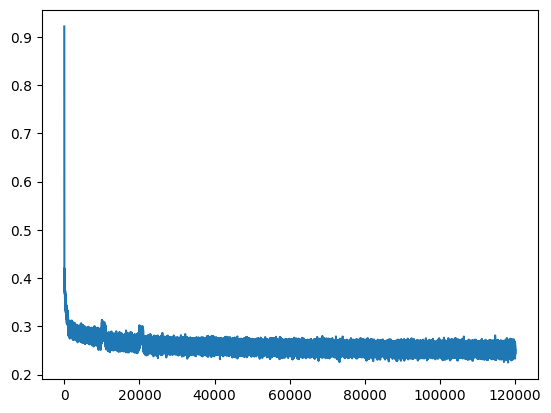

In [34]:
plt.plot(
    # lossi
    torch.tensor(lossi).view(-1, 100).mean(dim=1).flatten().tolist()
)

In [35]:
def evaluation(X, Y):
    emb = C[X]
    h = torch.tanh(emb.view(-1, input_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss.item()

# Overfit?
evaluation(Xtr, Ytr), evaluation(Xval, Yval)

(1.8061264753341675, 1.8034236431121826)

## Visualize embeddings

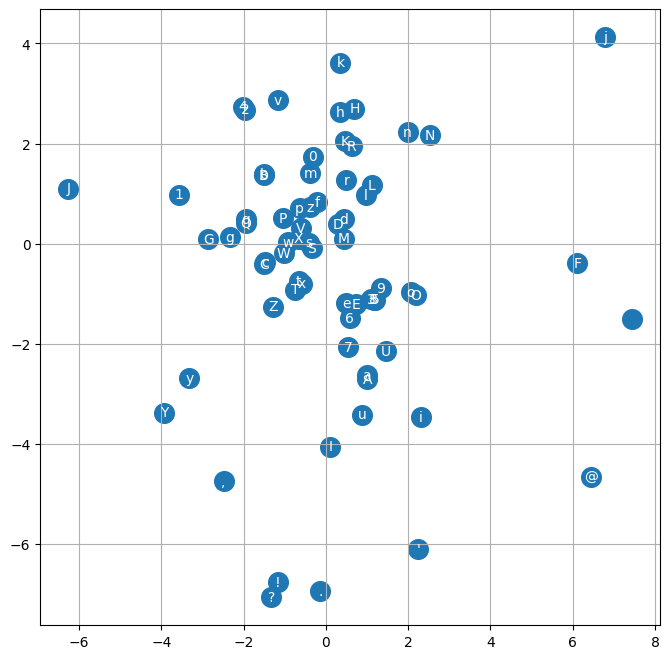

In [36]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(
        C[i, 0].item(), C[i, 1].item(), itos[i],
        ha="center", va="center", color="white")
plt.grid();

## Sample from mdoel

In [32]:
for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(-1, input_size) @ W1 + b1)
        logits = h @ W2 + b2
        prob = F.softmax(logits, dim=1)
        ix = torch.multinomial(prob, num_samples=1).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(ix)
    print(''.join([itos[i] for i in out]))

I to had greare liintey'ves wighting?
Hi!
Oh, it's gecgoze yow! Oh, wuen'ts kid ming! I'm not foin, tee got gabis wor is..Y'knowpeessnteswelly time be the on mut?
And cand cangs. Yer, in if 2ig mas done tixh is. Oh ine a living timlew foan um fean, guys tway somewlegis, and in, cant we on gre anmuy? I7 ever his 1ody and no, I'm all geeken, the reach! Ano? ineding lking!
Ceidedr think burt..
Imbe you, I'm huct. Leededt! if cites of that how. Junicau?
You not cecaiday, coys?

That?
I wome toney tnang okay I sriet letting you, I ceorterlerind on II helre. I hink on that afbovene tith this roben?
